## The objective of this code is to train a network in order to automatically adress the angle of a basal body 'isolated' on a image.


#### Two approaches (will) has been tested: 
- a classification method where each one of the 36 classes correspond to an angle of 10°
- a regressive method to get the 'exact' orientation of the basal bodies.  
  
.  
_**Important: So far (31 May 2020) Only the classification method is implemented**_
.  

In [1]:
# Define the method to use
problem = 'classification'

**Define working path**

In [2]:
cd c:\Users\breto\Desktop\Data_Analysis\Schmidtea_CNN\

c:\Users\breto\Desktop\Data_Analysis\Schmidtea_CNN


**Import modules**  

The full requirement on which the model was train can be found on the GitHub

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# To save 
import csv

if torch.cuda.is_available():                                  # Personal comment: Here rise an error if GPU not available
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.4.0  Device: cuda


In [4]:
device = torch.device('cpu')

### Data loading


In [5]:
from sklearn.model_selection import train_test_split

x = np.load('centriole_img_32pixels_validation.npy')
y = np.load('centriole_angle_32pixels_validation.npy')

x = x.astype('float64')

In [6]:
x = x.reshape((x.shape[0],1,32,32))

### 'Classification' of the angle

In [7]:
# For Classification method, transformation of the angle into class of n degree
n=10

if problem == 'classification':
    for j in range(y.shape[0]):
        if y[j] == 0:
            y[j] == 1
        else:
            i=0
            while (i*n) <= y[j]:
                i += 1
            y[j]=i
        if y[j] > 35:
            y[j] = 0

In [8]:
# Define the size of the batch to train the model more efficiently
batch_size = 50

# Transform the np array as adapted Tensor type
torch_x_validation = torch.from_numpy(x).type(torch.float)


if problem == 'classification':
    torch_y_validation = torch.from_numpy(y).type(torch.LongTensor)
    
else:
    torch_y_train_validation = torch.from_numpy(y).type(torch.float)


# Append the images (x) to the the output (~angle, y)
validation = torch.utils.data.TensorDataset(torch_x_validation,torch_y_validation)


# Use the DataLoader class of PyTorch
validation_loader = torch.utils.data.DataLoader(validation, batch_size = batch_size, shuffle = False)

**Data format checking**

In [9]:
# Check the format of (1 batch) of the loader
for (x_train, y_train) in validation_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

x_train: torch.Size([50, 1, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([50]) type: torch.LongTensor


### Example of images. 
In this project we want to orient the basal bodies (BBs) thanks to the direction pointed by its rootlet. As you can see on the images, BBs can be close one to each other but the only annotated BB on each picture is suppose to be the one the closer to the center of the image. The neighbour BB might be annotated in another image.

A shortcut is to consider that the BB correspond to the bright dot and the rootlet is the thin comet that emanate from it. To be more precise from a biological point of view, on these immunofluorescent images,  _Schmidtea Mediterranea_ was immunolabelled with anti-rootletin antibody and the bright dot correspond to the anchorage site of the rootlet at the BB. 
This site is not perfectly centered with the BB.

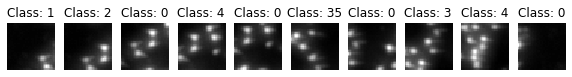

In [10]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(32,32), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

### Architecture of the Convolution Neural Network.

AlexNet was used as backbone of this CNN. As the images of the BBs are quite small (32*32) and in greyscale, I change most of the kernel size, padding and stride of Convolutional layer and Pooling Layer in order to don't reduce too much the output of each layer (The size of image and numbers of neurones is precise in the convolution block)

In [11]:
class SchmidteaNet(nn.Module):

    def __init__(self, num_classes=36):
        super(SchmidteaNet, self).__init__()
        self.features = nn.Sequential(                              # 32 * 32
            nn.Conv2d(1, 64, kernel_size=5, padding =2),            # 32 * 32  * 64            
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),                            # 16 * 16 * 64
            nn.Conv2d(64, 192, kernel_size=3, padding=1),           # 16 * 16 * 192
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(kernel_size=2),                            # 8 * 8 * 192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # 8 * 8 * 384
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # 8 * 8 * 256
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # 8 * 8 * 256
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 4 * 4 * 256 
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [12]:
model = SchmidteaNet()
model.load_state_dict(torch.load('SchmidteaNet_Weigths.pt'))
model.eval()

SchmidteaNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Con

**Model instanciation + transfer to device**  
By default, the device is the GPU  
!! Take Care, if GPU is not available the model will learn on CPU !!

**Choice of the optimizer**  
By default, Stochastic Gradient Descent is use as optimizer

**Choice of the criterion**  
By default, the loss function is set to Cross Entropy for classification and Mean Square Error for regression

In [13]:
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

if problem == 'classification':
    criterion = nn.CrossEntropyLoss()
else: 
    criterion = nn.MSELoss() #Do not use MSE it would be stupid


#### Definition of the 'train()' and 'test()' function to make the model learn  


In [112]:
def validate(model, loss_vector, accuracy_vector):
    '''
    Input of the function:
        model: neural network model in Pytorch
        loss_vector: empty array with is assigned by the function
        accuracy_vector: empty array with is assigned by the function
    '''
    list_output = []
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        # Pass data through the network
        output = model(data)
        val_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1)[1] 
        list_output.append(pred)
        correct += pred.eq(target.data).cpu().sum()
    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)
    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    # At the end of an epoch, print the precision of the current model weight
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
            .format(val_loss, correct, len(validation_loader.dataset), accuracy))
    return list_output

In [156]:
lossv, accv = [], []
prediction = validate(model, lossv, accv)


Validation set: Average loss: 3.0752, Accuracy: 596/813 (73%)

Annotation of 813 centriole in: 8.77s


###  Extraction of the prediction
Note: this code as to be optimize

In [116]:
to_list =[]
for i in prediction:
    j = i.numpy()
    for k in j:
        to_list.append(k)

In [119]:
y_pred = np.asarray(to_list)

### Quick Accuracy analysis

In [137]:
error = y-y_pred
occurrences = np.zeros(19)
for i in range(18):
    occurrences[i] = np.count_nonzero(abs(error) == i) + np.count_nonzero(abs(error) == (36-i))

error_ratio = occurrences/len(y)*100

print(error_ratio)

In [138]:
np.savetxt('validation_prediction.txt', y_pred, fmt="%d")